In [25]:
import torch
import ml4gw

import numpy as np
from ml4gw import gw
from ml4gw import transforms 
from ml4gw.spectral import fast_spectral_density, spectral_density
from ml4gw.transforms import SnrRescaler, Whiten
from ml4gw.transforms.transform import FittableSpectralTransform
from ml4gw.distributions import LogNormal, PowerLaw

from gasf_data.utils import h5_thang

%matplotlib inline

# Predefined function

#### Sampling

In [26]:
def masking(
    glitch_info: dict,
    segment_duration: float,
    segment_start_time: float=0,
    shift_range: float = 3, 
    pad_width: float = 1.5, # Make this default to half of the kernel width
    sample_rate: int=4096, 
    merge_edges: bool=True
)->dict:
    
    """Provide a buffer mask the covers the glitch at the center of the kernel.
    

    Args:
        glitch_info (dict): Glitch trigger times by each detector.
        segment_duration (float): Duration of the background.
        segment_start_time (float): Start time of the background. Defaults to 0.
        kernel_width (float, optional): The time width to cover a glitch signal.
        The unit is second. Defaults to 3.
        pad_width (float, optional)): 
        sample_rate (int, optional): The sampling rate of the background. Defaults to 4096.
        merge_edges (bool, optional): If true it will autometically conbine glitch masks 
        if the two kernels overlap.

    Returns:
        dict: A mask that labes the idxs that covers all glitch and edges 
        by the kernel start idx and end idx for each detectors. 
    """
    
    mask_kernel = {}
    if pad_width < shift_range/2:
        raise AttributeError(f"pad_width {pad_width} is shorter than half of the kernel_width {shift_range/2}")
    
    half_window = int(shift_range*sample_rate/2)
    seg_idx_count = segment_duration*sample_rate
    

    
    for ifo, glitch_time in glitch_info.items():
        
        # Initialing the first digits in the active segments aline to t0 = 0_sec
        glitch_time -= segment_start_time
        
        # Pop out glitch that lives in the edges
        ### This popping may need another argument passing.
        glitch_time = glitch_time[glitch_time > pad_width]
        glitch_time = glitch_time[glitch_time < segment_duration - pad_width]
        
        glitch_counts = len(glitch_time)
        mask_kernel[ifo] = np.zeros((glitch_counts+2, 2)).astype("int")
        
        # Provde the pad out edges mask
        mask_kernel[ifo][0, :] = np.array([0, pad_width*sample_rate])
        mask_kernel[ifo][-1, :] = np.array([seg_idx_count-pad_width*sample_rate, seg_idx_count])
        
        # Collecting the mask by idx
        glitch_idx = (glitch_time * 4096).astype("int")
        
        mask_kernel[ifo][1:-1, 0] = (glitch_idx - half_window)
        mask_kernel[ifo][1:-1, 1] = (glitch_idx + half_window)
        
    
    if merge_edges:
        
        for ifo, mask in mask_kernel.items():
            
            mask_counts = mask.shape[0]
            for i in range(mask_counts -1 ):
                
                if mask[i,1] > mask[i+1,0]:
                    mask[i,1] = mask[i+1,0]
                    
                    
    return mask_kernel


def filtering_idxs(
    mask_dict: dict,
    *n_idxs: int,
    full: bool=False,
):
    """Find segments that 

    Takes in the labeles 
    Args:
        mask_dict (dict): _description_
        segment_dur (float): _description_
        kernel_width (int, optional): _description_. Defaults to 2.
        sample_rate (int, optional): _description_. Defaults to 4096.
        shuffle (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    idx_dict = {}
    for ifo, mask in mask_dict.items():
    
        glitch_counts = len(mask)

        sampling_idx = []

        for i in range(glitch_counts-1):
            
            # Collecting usefull segments by its idx
            sampling_idx.append(torch.arange(mask[i,1], mask[i+1,0]))
            
        collected_idx = torch.cat(sampling_idx)
        
        
        if full:
            
            idx_dict[ifo] = collected_idx
        
            
        sampling_idx = torch.randint(0, len(collected_idx), n_idxs)

        idx_dict[ifo] = collected_idx[sampling_idx]
    
    return idx_dict


def strain_sampling(
    strain,
    mask: dict,
    sample_counts,
    sample_rate = 4096,
    kernel_width = 2,
):

    half_kernel_width_idx = int(kernel_width * sample_rate / 2)
    
    sampled_strain = torch.zeros([sample_counts, len(mask), sample_rate*kernel_width])

    # Cosider remove this part out of the function
    sampling_idx = filtering_idxs(
        mask, 
        sample_counts,
    )

    for _ , idxs in sampling_idx.items():
        for i, idx in enumerate(idxs):

            sampled_strain[i,:,:] = strain[:, idx-half_kernel_width_idx:idx+half_kernel_width_idx]
        
    return sampled_strain


def glitch_sampler(
    glitch_info,
    strain,
    segment_duration,
    segment_start_time,
    ifos,
    sample_counts,
    sample_rate = 4096,
    shift_range = 0.9,
    kernel_width = 3,
):
    
    half_kernel_width_idx = int(kernel_width * sample_rate / 2)
    
    sampled_strain = torch.zeros([sample_counts, len(ifos), sample_rate*kernel_width])

    mask_dict = masking(
        glitch_info,
        segment_duration=segment_duration,
        segment_start_time=segment_start_time,
        shift_range=shift_range,
        pad_width=kernel_width,
        sample_rate=sample_rate, 
        merge_edges = False
    )
    
    for i, ifo in enumerate(ifos):
        
        # Remove the padding mask
        mask_dict[ifo] = mask_dict[ifo][1:-1]
        
        glitch_count = len(mask_dict[ifo])
        # print(glitch_count)
        selected_glitch = np.random.randint(0, glitch_count, (sample_counts,))
        sample_center = np.random.randint(
            mask_dict[ifo][selected_glitch][:, 0], 
            mask_dict[ifo][selected_glitch][:, 1], 
            size=(sample_counts)
        )
        
        for j in range(sample_counts):
            
            start_idx = sample_center[j] - half_kernel_width_idx 
            end_idx = sample_center[j] + half_kernel_width_idx
            # print(strain[i, start_idx: end_idx].shape)
            sampled_strain[j, i, :] = strain[i, start_idx: end_idx]

    return sampled_strain

# Data Making

#### Global Variables

In [27]:
NUM_CHANNLES = 2

SAMPLE_RATE = 4096
FFTLENGTH = 2
OVERLAP = 1
BACKGROUND_DURATION = 4096
KERNEL_WIDTH = 8#8
WAVEFORM_DURATION = 8#8
HIGHPASS = 32

ITERATION = 20 # 5 batches of 2320 for total 11600
BATCH_SIZE = 116

MIN_SNR = 8
MAX_SNR = 50
ALPHA = 3
SNR_DISTRO = PowerLaw(MIN_SNR, MAX_SNR, ALPHA)

DATASTARTTIME = 1262469120
DATAENDTIME = 1262510080
DATATOTALTIME = DATAENDTIME - DATASTARTTIME

GPSSTARTTIME = 1262471488
GPSENDTIME = 1262507488
GPSTOTALTIME = GPSENDTIME-GPSSTARTTIME # SHOULD BE BACKGROUND_DURATION?
# BACKGROUND_DURATION = GPSTOTALTIME

STARTTIME = DATASTARTTIME + 4096*6

#### Some psudo data

In [28]:
# strain = torch.randn(NUM_CHANNLES, SAMPLE_RATE*BACKGROUND_DURATION)
# signals = torch.randn(ITERATION*BATCH_SIZE, NUM_CHANNLES, SAMPLE_RATE*WAVEFORM_DURATION)

# glitch_info = {
#     'H1/time': np.sort(np.random.uniform(0+0.5, BACKGROUND_DURATION-0.5, 3046)), 
#     'L1/time': np.sort(np.random.uniform(0+0.5, BACKGROUND_DURATION-0.5, 3046))
# }

# glitch_idx_h1 = (glitch_info['H1/time']*SAMPLE_RATE).astype("int")
# glitch_idx_l1 = (glitch_info['L1/time']*SAMPLE_RATE).astype("int")
   
# GPSSTARTTIME = 0

#### Some Real data

In [29]:
# Filenames
base_path = '/home/dfredin/gwgasf/data/'
signalsFilename = base_path + 'BBH_project.h5'
glitchFilename = base_path + 'glitch_info.h5'

# H1strainFilenames = [base_path + f'H1/H-H1_GWOSC_O3b_4KHZ_R1-{1262469120 + i*4096}-4096.hdf5' for i in range(10)]
# L1strainFilenames = [base_path + f'L1/L-L1_GWOSC_O3b_4KHZ_R1-{1262469120 + i*4096}-4096.hdf5' for i in range(10)]

H1strainFilenames = [base_path + f'H1/H-H1_GWOSC_O3b_4KHZ_R1-{1262469120 + i*4096}-4096.hdf5' for i in range(10)]
L1strainFilenames = [base_path + f'L1/L-L1_GWOSC_O3b_4KHZ_R1-{1262469120 + i*4096}-4096.hdf5' for i in range(10)]

# BBH Signals
signal_info = h5_thang(signalsFilename).h5_data()
signal_bbh_H1 = signal_info['waveforms_H1']
signal_bbh_L1 = signal_info['waveforms_L1']

signals = torch.FloatTensor(np.stack([signal_bbh_H1, signal_bbh_L1], axis=1))
signalstest = signals
signals = signals[:ITERATION*BATCH_SIZE,:,:]

del signal_bbh_H1, signal_bbh_L1

# LIGO Strain
strain_keys = h5_thang(H1strainFilenames[0]).h5_keys()

# H1 strain
H1strain = np.concatenate([np.array(h5_thang(filename).h5_data()['strain/Strain']) for filename in H1strainFilenames])
# L1 strain
L1strain = np.concatenate([np.array(h5_thang(filename).h5_data()['strain/Strain']) for filename in L1strainFilenames])
strain = torch.FloatTensor(np.stack([H1strain, L1strain], axis=0))
del H1strain, L1strain

# Glitches
glitch_list = 'H1/time','L1/time'
glitch_info = h5_thang(glitchFilename).h5_data(glitch_list)

glitchGPStime_h1 = np.array(glitch_info['H1/time'])
glitchGPStime_l1 = np.array(glitch_info['L1/time'])

glitch_idx_h1 = (((glitchGPStime_h1-DATASTARTTIME))*SAMPLE_RATE).astype("int")
# glitch_idx_l1 = (((glitchGPStime_l1[0:3046]-DATASTARTTIME))*SAMPLE_RATE).astype("int")
glitch_idx_l1 = (((glitchGPStime_l1-DATASTARTTIME))*SAMPLE_RATE).astype("int")





# del glitchGPStime_h1, glitchGPStime_l1

# begin_slice = (STARTTIME-DATASTARTTIME)*SAMPLE_RATE
# end_slice = (STARTTIME-DATASTARTTIME+BACKGROUND_DURATION)*SAMPLE_RATE
# strain = strain[:,begin_slice:end_slice]
strain.size()


: 

In [ ]:
# half_glitch_idx_span = 2048
# glitch_amp = 3e-23

# contaminated_strain = strain

# for pulse in glitch_idx_h1:
#     contaminated_strain[0, (pulse-half_glitch_idx_span):pulse+half_glitch_idx_span] += glitch_amp*torch.randn((2*half_glitch_idx_span))
    
# for pulse in glitch_idx_l1:
#     contaminated_strain[1, (pulse-half_glitch_idx_span):pulse+half_glitch_idx_span] += glitch_amp*torch.randn((2*half_glitch_idx_span))
    
    
# begin_slice = (STARTTIME-DATASTARTTIME)*SAMPLE_RATE
# end_slice = (STARTTIME-DATASTARTTIME+BACKGROUND_DURATION)*SAMPLE_RATE
# contaminated_strain = contaminated_strain[:,begin_slice:end_slice]
# contaminated_strain.size()

# # del glitch_idx_h1, glitch_idx_l1, strain

In [ ]:
contaminated_strain = strain

begin_slice = (STARTTIME-DATASTARTTIME)*SAMPLE_RATE
end_slice = (STARTTIME-DATASTARTTIME+BACKGROUND_DURATION)*SAMPLE_RATE
contaminated_strain = contaminated_strain[:,begin_slice:end_slice]
contaminated_strain.size()

torch.Size([2, 16777216])

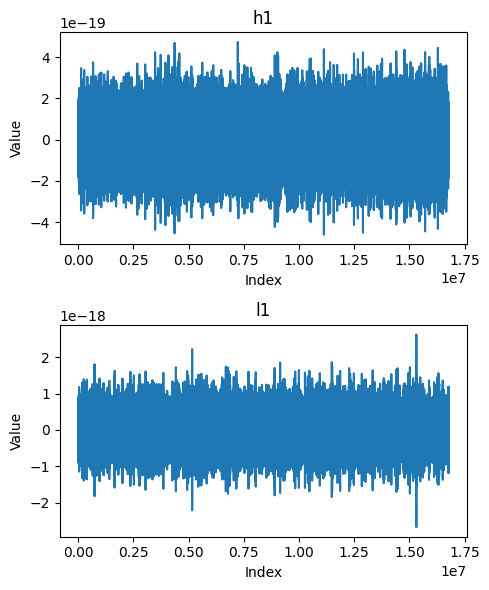

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, figsize=(5, 6))
h1 = contaminated_strain[0].numpy()
l1 = contaminated_strain[1].numpy()

# Plot b1 on the first subplot
axs[0].plot(h1)
axs[0].set_title('h1')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot b2 on the second subplot
axs[1].plot(l1)
axs[1].set_title('l1')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

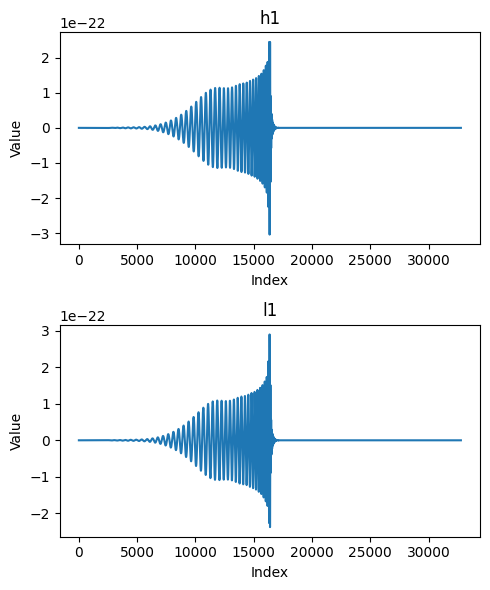

In [ ]:

fig, axs = plt.subplots(2, figsize=(5, 6))
h1 = signals[0,0,:].numpy()
l1 = signals[0,1,:].numpy()

# Plot b1 on the first subplot
axs[0].plot(h1)
axs[0].set_title('h1')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot b2 on the second subplot
axs[1].plot(l1)
axs[1].set_title('l1')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:

strain = strain[:,begin_slice:end_slice]

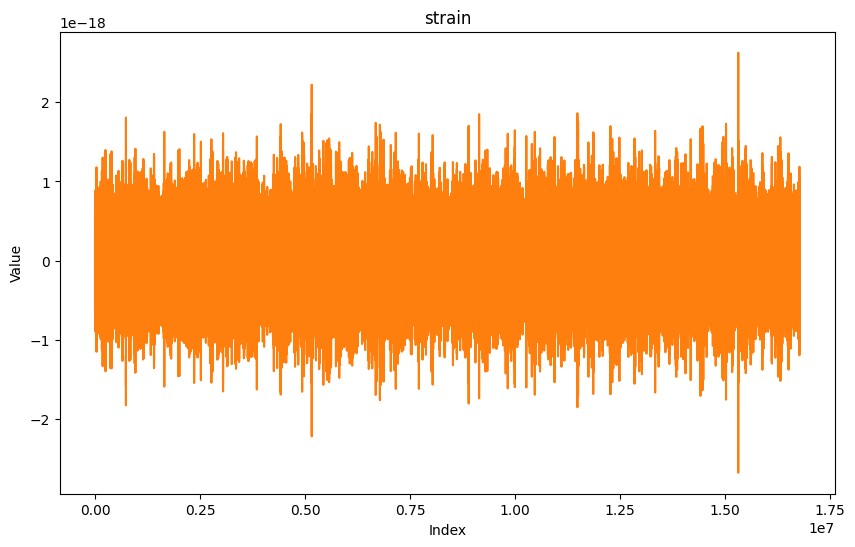

In [ ]:
import matplotlib.pyplot as plt

# Assuming background_data is a 2D tensor, we can plot the first row
strainh1 = strain[0].numpy()
strainl1 = strain[1].numpy()

plt.figure(figsize=(10, 6))
plt.plot(strainh1)
plt.plot(strainl1)
plt.title('strain')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

#### Precauculate_PSD

In [ ]:
# This is served for more detailed control 
spec_trans = FittableSpectralTransform()

psds = torch.empty([NUM_CHANNLES, int((SAMPLE_RATE*KERNEL_WIDTH)/2) +1])

psds[0, :] = spec_trans.normalize_psd(
    contaminated_strain[0],
    sample_rate=SAMPLE_RATE,
    num_freqs=int((SAMPLE_RATE*KERNEL_WIDTH)/2) +1,
    fftlength=FFTLENGTH,
    overlap=OVERLAP,
)

psds[1, :] = spec_trans.normalize_psd(
    contaminated_strain[1],
    sample_rate=SAMPLE_RATE,
    num_freqs=int((SAMPLE_RATE*KERNEL_WIDTH)/2) +1,
    fftlength=FFTLENGTH,
    overlap=OVERLAP,
)

#### Sampling BG

In [ ]:
# Background

mask_dict = masking(
    glitch_info,
    segment_duration=BACKGROUND_DURATION,
    shift_range=KERNEL_WIDTH,
    pad_width=KERNEL_WIDTH/2,
    merge_edges = True
)

background = strain_sampling(
    contaminated_strain,
    mask_dict,
    sample_counts=ITERATION*BATCH_SIZE,
    kernel_width=KERNEL_WIDTH
)

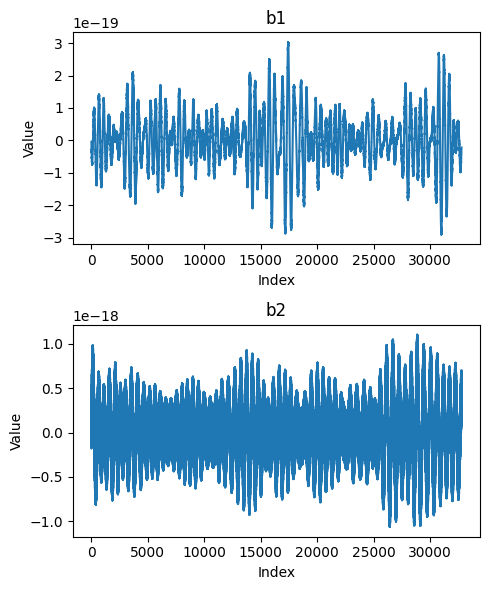

In [ ]:
fig, axs = plt.subplots(2, figsize=(5, 6))

b1 = background[113,0,:].numpy()
b2 = background[113,1,:].numpy()


# Plot b1 on the first subplot
axs[0].plot(b1)
axs[0].set_title('b1')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot b2 on the second subplot
axs[1].plot(b2)
axs[1].set_title('b2')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

#### Sampling Glitch

In [ ]:
# Glitch data

glitches = glitch_sampler(
    glitch_info=glitch_info,
    strain = contaminated_strain,
    segment_duration = BACKGROUND_DURATION,
    segment_start_time = STARTTIME,
    ifos = ['H1/time', 'L1/time'],
    sample_counts = ITERATION*BATCH_SIZE,
    sample_rate = SAMPLE_RATE,
    shift_range = 0.9,
    kernel_width = KERNEL_WIDTH
)

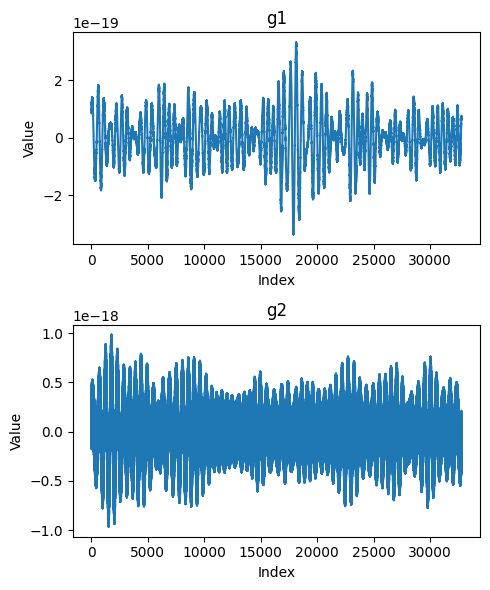

In [ ]:
fig, axs = plt.subplots(2, figsize=(5, 6))
g1 = glitches[5,0,:].numpy()
g2 = glitches[5,1,:].numpy()

# Plot b1 on the first subplot
axs[0].plot(g1)
axs[0].set_title('g1')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot b2 on the second subplot
axs[1].plot(g2)
axs[1].set_title('g2')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
psds[0,0]

tensor(1.3565e-42)

#### Sampling Injections

In [ ]:
# Injection

mask_dict = masking(
    glitch_info,
    segment_duration=BACKGROUND_DURATION,
    shift_range=KERNEL_WIDTH,
    pad_width=KERNEL_WIDTH/2,
    merge_edges = True
)

####
sampled_bg = strain_sampling(
    contaminated_strain,
    mask_dict,
    sample_counts=ITERATION*BATCH_SIZE,
    kernel_width=KERNEL_WIDTH
)

# Initalizing some class

rescaler = SnrRescaler(
    num_channels=NUM_CHANNLES, 
    sample_rate = SAMPLE_RATE,
    waveform_duration = WAVEFORM_DURATION
)

# rescaler = SnrRescaler(
#     num_channels=NUM_CHANNLES, 
#     sample_rate = SAMPLE_RATE,
#     waveform_duration = WAVEFORM_DURATION,
#     highpass = HIGHPASS,
# )

#########
rescaler.fit(
    contaminated_strain[0],
    contaminated_strain[1],
    fftlength=FFTLENGTH,
    overlap=OVERLAP,
)
    



# rescaler.fit(
#     contaminated_strain[0].clone().detach(),
#     contaminated_strain[1].clone().detach(),
#     fftlength=FFTLENGTH,
#     overlap=OVERLAP,
# )

# rescaler.fit(
#     psds[0].clone().detach(),
#     psds[1].clone().detach(),
#     fftlength=FFTLENGTH,
#     overlap=OVERLAP,
# )
    




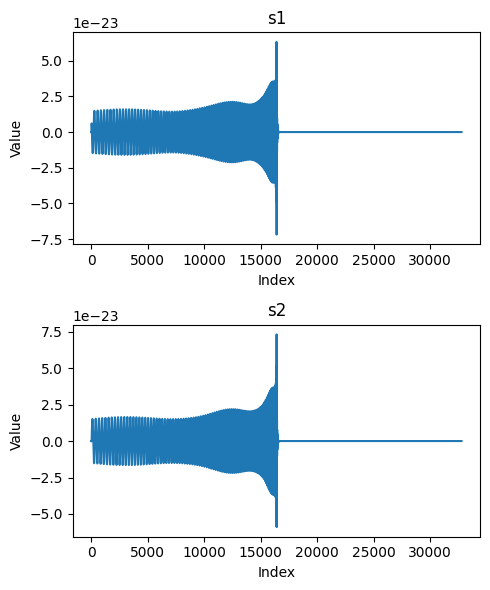

In [ ]:
fig, axs = plt.subplots(2, figsize=(5, 6))
s1 = signals[5,0,:].numpy()
s2 = signals[5,1,:].numpy()

# Plot b1 on the first subplot
axs[0].plot(s1)
axs[0].set_title('s1')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot b2 on the second subplot
axs[1].plot(s2)
axs[1].set_title('s2')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:

rescaled_signals, target_snrs = rescaler.forward(
    signals,
    target_snrs=SNR_DISTRO(BATCH_SIZE*ITERATION)
)

# rescaled_signals, target_snrs = rescaler.forward(
#     signals
# )

injection = sampled_bg + rescaled_signals

# del contaminated_strain, sampled_bg, rescaled_signals, signals

import gc
gc.collect()

26046

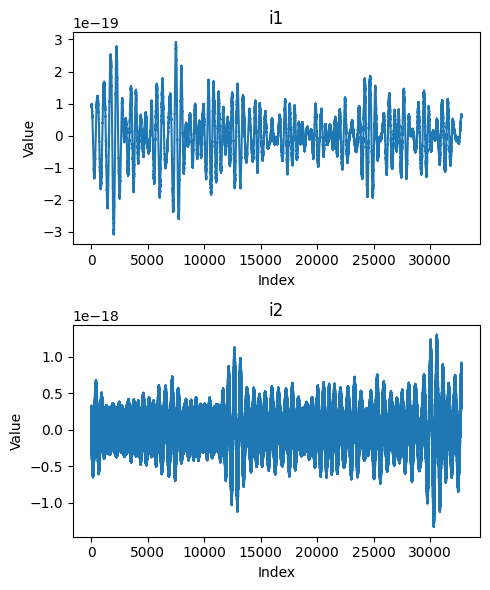

In [ ]:
fig, axs = plt.subplots(2, figsize=(5, 6))
i1 = injection[5,0,:].numpy()
i2 = injection[5,1,:].numpy()

# Plot b1 on the first subplot
axs[0].plot(i1)
axs[0].set_title('i1')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot b2 on the second subplot
axs[1].plot(i2)
axs[1].set_title('i2')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
background.shape, injection.shape, glitches.shape

(torch.Size([2320, 2, 32768]),
 torch.Size([2320, 2, 32768]),
 torch.Size([2320, 2, 32768]))

In [ ]:
testing = injection - background

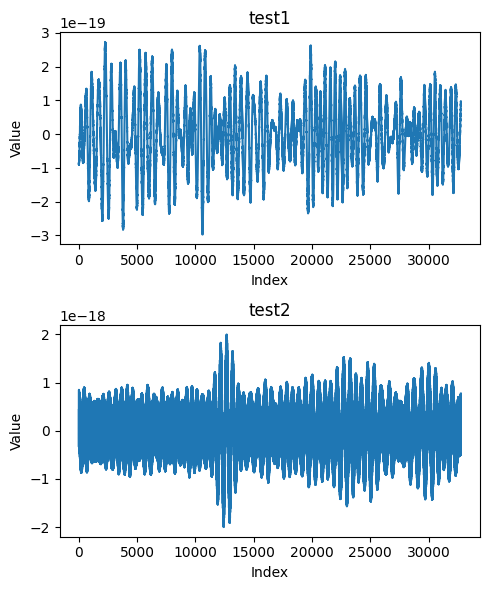

In [ ]:
fig, axs = plt.subplots(2, figsize=(5, 6))
test1 = testing[5,0,:].numpy()
test2 = testing[5,1,:].numpy()

# Plot b1 on the first subplot
axs[0].plot(test1)
axs[0].set_title('test1')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Plot b2 on the second subplot
axs[1].plot(test2)
axs[1].set_title('test2')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
whiten_model = Whiten(
    FFTLENGTH,
    SAMPLE_RATE,
    HIGHPASS
)

In [ ]:
background_data = whiten_model(
    background, 
    psds
)

del background

In [ ]:
injected_data = whiten_model(
    injection,
    psds
)
del injection

In [ ]:
glitch_data = whiten_model(
    glitches,
    psds
)
del glitches, psds


In [ ]:
background_data.shape, injected_data.shape, glitch_data.shape

### Save Data

In [ ]:
import h5py

SAVEFILENAME = base_path + 'TESTdata.h5'

# Convert tensors to numpy arrays
background_data_np = background_data.numpy()
injected_data_np = injected_data.numpy()
glitch_data_np = glitch_data.numpy()

# Open an HDF5 file in write mode ('w')
with h5py.File(SAVEFILENAME, 'w') as file:

    # Create datasets within the first group
    file.create_dataset('background', data=background_data_np)
    file.create_dataset('injected_bbh', data=injected_data_np)
    file.create_dataset('glitch', data=glitch_data_np)
    
    file.close()

In [ ]:
# import h5py

# SAVEFILENAME = base_path + 'TESTdata.h5'

# # Convert tensors to numpy arrays
# background_data_np = background_data.numpy()
# injected_data_np = injected_data.numpy()
# glitch_data_np = glitch_data.numpy()

# # Open an HDF5 file in write mode ('w')
# with h5py.File(SAVEFILENAME, 'w') as file:

#     # Create the first group
#     h1 = file.create_group('H1')

#     # Create datasets within the first group
#     h1.create_dataset('background', data=background_data_np[:,0,:])
#     h1.create_dataset('injected_bbh', data=injected_data_np[:,0,:])
#     h1.create_dataset('glitch', data=glitch_data_np[:,0,:])


#     # Create the first group
#     l1 = file.create_group('L1')

#     # Create datasets within the first group
#     l1.create_dataset('background', data=background_data_np[:,1,:])
#     l1.create_dataset('injected_bbh', data=injected_data_np[:,1,:])
#     l1.create_dataset('glitch', data=glitch_data_np[:,1,:])

#     file.close()